In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-smartphone-decimeter-challenge/sample_submission.csv
/kaggle/input/google-smartphone-decimeter-challenge/baseline_locations_train.csv
/kaggle/input/google-smartphone-decimeter-challenge/baseline_locations_test.csv
/kaggle/input/google-smartphone-decimeter-challenge/metadata/constellation_type_mapping.csv
/kaggle/input/google-smartphone-decimeter-challenge/metadata/accumulated_delta_range_state_bit_map.json
/kaggle/input/google-smartphone-decimeter-challenge/metadata/raw_state_bit_map.json
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/SamsungS20Ultra_derived.csv
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/supplemental/SamsungS20Ultra_GnssLog.21o
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/Pixel5/Pixel5_derived.csv
/kaggl

In [2]:
! pip3 install simdkalman

import keras 
import os
import haversine 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import pathlib
import plotly
from datetime import datetime 
import plotly.express as px 
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt 
from sklearn import linear_model  
from sklearn.ensemble import IsolationForest 
import warnings
from sklearn.model_selection import KFold
from numba import jit
import joblib
import numpy as np
import pandas as pd
# import modin.pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.layers import LeakyReLU, Input, concatenate, Dense, LSTM, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation, Reshape, Embedding, Add, Subtract, LeakyReLU, Flatten, AdditiveAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.metrics import AUC 
from tensorflow.keras.activations import swish, relu
from tensorflow.keras.backend import square 
from keras.engine.topology import Layer 
from keras import backend as K
import warnings 
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
import random 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler
import simdkalman
from pathlib import Path
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
import gc 
from sklearn.metrics import r2_score
seeds = [2022]
warnings.filterwarnings("ignore")

In [3]:
train_pd = pd.read_csv("../input/feature-eng/trainset_pandas.csv")
val_pd = pd.read_csv("../input/feature-eng/valset_pandas.csv")
test_data = pd.read_csv("../input/feature-eng/testset_pandas.csv")

train_data = pd.read_csv("../input/feature-eng/total_trainset_pandas.csv")

In [4]:
train_pd[[col for col in train_pd.columns if 'speed' in col]].describe()

,speedMps
count,73926.000000
mean,18.178612
std,12.723867
min,0.000000
25%,4.910000
50%,22.620000
75%,29.080000
max,45.010000


In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def create_timediff_v_a(df):
    # df = pd_train
    df_ = df.copy()
    df_['millisSinceGpsEpoch_diff'] = df_['millisSinceGpsEpoch_shift_-1'] - df_['millisSinceGpsEpoch']
    
    df_['dis'] = df_.apply(lambda x: calc_haversine(x['latDeg'], x['lngDeg'], x['latDeg_shift_-1'], x['lngDeg_shift_-1']), axis=1)
    df_['speed'] = 1000 * df_['dis'] / df_['millisSinceGpsEpoch_diff']
    return df_ 

def create_shift_features(df, shift_list, shift_columns, group_name, use_col):
    tmp_shift = df.copy()
    
    for shift_i in shift_list:
        tmp_test = tmp_shift.groupby(group_name).shift(shift_i)
        for col in shift_columns:
            tmp_name = col + '_shift_' + str(shift_i)
            if tmp_name not in use_col:
                tmp_shift[tmp_name] =  tmp_test[col]
            else:
                print('out col : {}'.format(tmp_name))
                continue
    return tmp_shift 

In [6]:
train_pd.shape, test_data.shape

((73926, 133), (91486, 124))

In [7]:
print('1. create_shift_features')
use_cols = []
shift_list = [-1, 1]
shift_columns = ['millisSinceGpsEpoch',
                 'latDeg','lngDeg']
group_name = ['phone']
train_pd = create_shift_features(train_pd, shift_list, shift_columns, group_name, use_cols)
val_pd = create_shift_features(val_pd, shift_list, shift_columns, group_name, use_cols)
test_data = create_shift_features(test_data, shift_list, shift_columns, group_name, use_cols)

1. create_shift_features


In [8]:
train_pd.shape, test_data.shape

((73926, 139), (91486, 130))

In [9]:
train_pd = create_timediff_v_a(train_pd)
val_pd = create_timediff_v_a(val_pd)

In [10]:
train_pd.speedMps.describe()

count    73926.000000
mean        18.178612
std         12.723867
min          0.000000
25%          4.910000
50%         22.620000
75%         29.080000
max         45.010000
Name: speedMps, dtype: float64

In [11]:
train_pd.speed.describe()

count    73886.000000
mean        19.568232
std         46.114203
min          0.000000
25%          7.155320
50%         22.922342
75%         29.210460
max       8340.325453
Name: speed, dtype: float64

In [12]:
train_pd['speed_between_baseline_and_truth'] = abs(train_pd['speed'] - train_pd['speedMps']).fillna(0)
val_pd['speed_between_baseline_and_truth'] = abs(val_pd['speed'] - val_pd['speedMps']).fillna(0)

In [13]:
cat_cols = [
    'correctedPrm_avg_bucketized',
    'rawPrUncM_avg_bucketized',
    'satClkDriftMps_avg_bucketized',
    'correctedPrm_std_bucketized',
    'rawPrUncM_std_bucketized',
    'satClkDriftMps_std_bucketized',
    "phoneCat"
]

numerical_cols = [
     'latDeg',
     'lngDeg',
     'heightAboveWgs84EllipsoidM',
     'ratio_of_year',
     'mean_latDeg+-1',
     'mean_lngDeg+-1',
     'latDeg_mean_delta_1',
     'lngDeg_mean_delta_1',
     'mean_latDeg+-2',
     'mean_lngDeg+-2',
     'latDeg_mean_delta_2',
     'lngDeg_mean_delta_2',
     'mean_latDeg+-3',
     'mean_lngDeg+-3',
     'latDeg_mean_delta_3',
     'lngDeg_mean_delta_3',
     'mean_latDeg+-4',
     'mean_lngDeg+-4',
     'latDeg_mean_delta_4',
     'lngDeg_mean_delta_4',
     'mean_latDeg+-5',
     'mean_lngDeg+-5',
     'latDeg_mean_delta_5',
     'lngDeg_mean_delta_5',
     'latDeg_pre_increment',
     'lngDeg_pre_increment',
     'latDeg_post_increment',
     'lngDeg_post_increment',
     'dist_pre',
     'dist_post',
     'latDeg_pre_post_mean_abs_delta',
     'lngDeg_pre_post_mean_abs_delta',
     'pre_post_mean_abs_dist',
     'max_latDeg_with_same_millisSinceGpsEpoch',
     'max_lngDeg_with_same_millisSinceGpsEpoch',
     'max_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'min_latDeg_with_same_millisSinceGpsEpoch',
     'min_lngDeg_with_same_millisSinceGpsEpoch',
     'min_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'mean_latDeg_with_same_millisSinceGpsEpoch',
     'mean_lngDeg_with_same_millisSinceGpsEpoch',
     'mean_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'sum_latDeg_with_same_millisSinceGpsEpoch',
     'sum_lngDeg_with_same_millisSinceGpsEpoch',
     'sum_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'count_latDeg_with_same_millisSinceGpsEpoch',
     'dist_between_baseline_and_phone_mean',
     'Cn0DbHz_avg',
     'BiasUncertaintyNanos_avg',
     'Cn0DbHz_std',
     'BiasUncertaintyNanos_std',
     'UncalAccelXMps2_avg',
     'UncalAccelYMps2_avg',
     'UncalAccelZMps2_avg',
     'UncalAccelXMps2_std',
     'UncalAccelYMps2_std',
     'UncalAccelZMps2_std',
     'UncalGyroXRadPerSec_avg',
     'UncalGyroYRadPerSec_avg',
     'UncalGyroZRadPerSec_avg',
     'UncalGyroXRadPerSec_std',
     'UncalGyroYRadPerSec_std',
     'UncalGyroZRadPerSec_std',
     'UncalMagXMicroT_avg',
     'UncalMagYMicroT_avg',
     'UncalMagZMicroT_avg',
     'UncalMagXMicroT_std',
     'UncalMagYMicroT_std',
     'UncalMagZMicroT_std',
     'latDeg_kf',
     'lngDeg_kf',
     'dist_between_base_and_kf',
     'base_kf_lat_delta',
     'base_kf_lng_delta',
     'abs_base_kf_lng_delta',
     'abs_base_kf_lat_delta'
]

feature_cols = [
     'latDeg',
     'lngDeg',
     'heightAboveWgs84EllipsoidM',
     'phoneCat',
     'ratio_of_year',
     'mean_latDeg+-1',
     'mean_lngDeg+-1',
     'latDeg_mean_delta_1',
     'lngDeg_mean_delta_1',
     'mean_latDeg+-2',
     'mean_lngDeg+-2',
     'latDeg_mean_delta_2',
     'lngDeg_mean_delta_2',
     'mean_latDeg+-3',
     'mean_lngDeg+-3',
     'latDeg_mean_delta_3',
     'lngDeg_mean_delta_3',
     'mean_latDeg+-4',
     'mean_lngDeg+-4',
     'latDeg_mean_delta_4',
     'lngDeg_mean_delta_4',
     'mean_latDeg+-5',
     'mean_lngDeg+-5',
     'latDeg_mean_delta_5',
     'lngDeg_mean_delta_5',
     'latDeg_pre_increment',
     'lngDeg_pre_increment',
     'latDeg_post_increment',
     'lngDeg_post_increment',
     'dist_pre',
     'dist_post',
     'latDeg_pre_post_mean_abs_delta',
     'lngDeg_pre_post_mean_abs_delta',
     'pre_post_mean_abs_dist',
     'max_latDeg_with_same_millisSinceGpsEpoch',
     'max_lngDeg_with_same_millisSinceGpsEpoch',
     'max_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'min_latDeg_with_same_millisSinceGpsEpoch',
     'min_lngDeg_with_same_millisSinceGpsEpoch',
     'min_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'mean_latDeg_with_same_millisSinceGpsEpoch',
     'mean_lngDeg_with_same_millisSinceGpsEpoch',
     'mean_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'sum_latDeg_with_same_millisSinceGpsEpoch',
     'sum_lngDeg_with_same_millisSinceGpsEpoch',
     'sum_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'count_latDeg_with_same_millisSinceGpsEpoch',
     'dist_between_baseline_and_phone_mean',
     'correctedPrm_avg_bucketized',
     'rawPrUncM_avg_bucketized',
     'satClkDriftMps_avg_bucketized',
     'correctedPrm_std_bucketized',
     'rawPrUncM_std_bucketized',
     'satClkDriftMps_std_bucketized',
     'Cn0DbHz_avg',
     'BiasUncertaintyNanos_avg',
     'Cn0DbHz_std',
     'BiasUncertaintyNanos_std',
     'UncalAccelXMps2_avg',
     'UncalAccelYMps2_avg',
     'UncalAccelZMps2_avg',
     'UncalAccelXMps2_std',
     'UncalAccelYMps2_std',
     'UncalAccelZMps2_std',
     'UncalGyroXRadPerSec_avg',
     'UncalGyroYRadPerSec_avg',
     'UncalGyroZRadPerSec_avg',
     'UncalGyroXRadPerSec_std',
     'UncalGyroYRadPerSec_std',
     'UncalGyroZRadPerSec_std',
     'UncalMagXMicroT_avg',
     'UncalMagYMicroT_avg',
     'UncalMagZMicroT_avg',
     'UncalMagXMicroT_std',
     'UncalMagYMicroT_std',
     'UncalMagZMicroT_std',
     'latDeg_kf',
     'lngDeg_kf',
     'dist_between_base_and_kf',
     'base_kf_lat_delta',
     'base_kf_lng_delta',
     'abs_base_kf_lng_delta',
     'abs_base_kf_lat_delta'
]
label_cols = ["speed_between_baseline_and_truth"]
# label_cols = ["dist_between_baseline_and_truth"]

xtr = train_pd[feature_cols]
ytr = train_pd[label_cols]
xval = val_pd[feature_cols]
yval = val_pd[label_cols]

In [14]:
xtr_num = xtr[numerical_cols]
xval_num = xval[numerical_cols]

xtr_cat_one_hot_1 = pd.get_dummies(xtr[[cat_cols[0]]].astype('str'))
xtr_cat_one_hot_2 = pd.get_dummies(xtr[[cat_cols[1]]].astype('str'))
xtr_cat_one_hot_3 = pd.get_dummies(xtr[[cat_cols[2]]].astype('str'))
xtr_cat_one_hot_4 = pd.get_dummies(xtr[[cat_cols[3]]].astype('str'))
xtr_cat_one_hot_5 = pd.get_dummies(xtr[[cat_cols[4]]].astype('str'))
xtr_cat_one_hot_6 = pd.get_dummies(xtr[[cat_cols[5]]].astype('str'))
xtr_cat_one_hot_7 = pd.get_dummies(xtr[[cat_cols[6]]].astype('str'))

xval_cat_one_hot_1 = pd.get_dummies(xval[[cat_cols[0]]].astype('str'))
xval_cat_one_hot_2 = pd.get_dummies(xval[[cat_cols[1]]].astype('str'))
xval_cat_one_hot_3 = pd.get_dummies(xval[[cat_cols[2]]].astype('str'))
xval_cat_one_hot_4 = pd.get_dummies(xval[[cat_cols[3]]].astype('str'))
xval_cat_one_hot_5 = pd.get_dummies(xval[[cat_cols[4]]].astype('str'))
xval_cat_one_hot_6 = pd.get_dummies(xval[[cat_cols[5]]].astype('str'))
xval_cat_one_hot_7 = pd.get_dummies(xval[[cat_cols[6]]].astype('str'))

In [15]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()

In [16]:
xtr_num = ss.fit_transform(xtr_num)
xval_num = ss.transform(xval_num)

In [17]:
def my_loss(y_true, y_pred):
    loss_less = 1.0 
    loss_more = 2.0 
    
    error = y_pred - y_true
    error_fix = tf.where(tf.greater(y_pred, y_true), error * loss_less, - error * loss_more)
    mae_fix = K.mean(error_fix)
    return mae_fix

def check_random(SEED=2021):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def nns(x, hidden_units, activation, dropout_rates):
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i])(x)
        x = BatchNormalization()(x)
        x = Activation(activation[i])(x)
        x = Dropout(dropout_rates[i + 1])(x)
    return x     

def create_nn_model_new(
    num_cols, cat_cols_list, output_dim, learning_rate
):

    inp = Input(shape=(num_cols,))

    inp_cat1 = Input(shape=(cat_cols_list[0],))
    inp_cat2 = Input(shape=(cat_cols_list[1],))
    inp_cat3 = Input(shape=(cat_cols_list[2],))
    inp_cat4 = Input(shape=(cat_cols_list[3],))
    inp_cat5 = Input(shape=(cat_cols_list[4],))
    inp_cat6 = Input(shape=(cat_cols_list[5],))
    inp_cat7 = Input(shape=(cat_cols_list[6],))

    dense_cats = []
    dense_cats.append(Dense(50)(inp_cat1))
    dense_cats.append(Dense(50)(inp_cat2))
    dense_cats.append(Dense(50)(inp_cat3))
    dense_cats.append(Dense(50)(inp_cat4))
    dense_cats.append(Dense(50)(inp_cat5))
    dense_cats.append(Dense(50)(inp_cat6))
    dense_cats.append(Dense(50)(inp_cat7))

#     x = Concatenate(axis=-1)([inp, 1 / (inp + 1e-20), tf.keras.backend.log(tf.abs(inp))] + dense_cats)
    x = Concatenate(axis=-1)(dense_cats + [inp])
    x = Dense(512)(x)
    x = Activation(relu)(x)
    
#     x = nns(x, [512, 256, 128, 64], [relu, relu, relu, relu], [0.01, 0.01, 0.1, 0.1, 0.1])
    
    x = Dense(512)(x)
    x = Activation(relu)(x)
    
    x = Dense(256)(x)
    x = Activation(relu)(x)
    
    x = Dense(128)(x)
    x = Activation(relu)(x)
    
    x = Dense(64)(x)

    out = Dense(output_dim)(x)

    model = Model(inputs=[inp, 
                        inp_cat1, inp_cat2, 
                        inp_cat3, inp_cat4,
                        inp_cat5, inp_cat6, 
                        inp_cat7], outputs=out)
    model.compile(
#         optimizer=AdamW(learning_rate=learning_rate, weight_decay=0.01),
        optimizer=AdamW(learning_rate=learning_rate, weight_decay=0.0001),
#         optimizer='rmsprop',
        loss=[my_loss],
        metrics=['mae', 'mse']
    )

    return model 
    
check_random()
file_name = 'ann_speed'

In [18]:
epochs = 200
batch_size = 1024
learning_rate = 0.005

In [19]:
check_random()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.1, patience=8,  mode='min')

earlystop_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath='lr_{}.hdf5'.format(file_name),
    verbose=10,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

ann = create_nn_model_new(xtr_num.shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, learning_rate)
ann.summary()

ann.fit([xtr_num, xtr_cat_one_hot_1, xtr_cat_one_hot_2, xtr_cat_one_hot_3, 
         xtr_cat_one_hot_4, xtr_cat_one_hot_5, xtr_cat_one_hot_6, xtr_cat_one_hot_7], 
        ytr, 
        epochs=epochs, 
        batch_size=batch_size,  
        validation_data=([xval_num, xval_cat_one_hot_1, xval_cat_one_hot_2, xval_cat_one_hot_3, 
                          xval_cat_one_hot_4, xval_cat_one_hot_5, xval_cat_one_hot_6, xval_cat_one_hot_7], 
                         yval),
        callbacks=[reduce_lr,
                   earlystop_callback,
                   model_checkpoint_callback]
       )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 21)]         0                                            
______________________________________________________________________________________________

In [20]:
test = test_data[feature_cols]

In [21]:
test_num = test[numerical_cols]

test_cat_one_hot_1 = pd.get_dummies(test[[cat_cols[0]]].astype('str'))
test_cat_one_hot_2 = pd.get_dummies(test[[cat_cols[1]]].astype('str'))
test_cat_one_hot_3 = pd.get_dummies(test[[cat_cols[2]]].astype('str'))
test_cat_one_hot_4 = pd.get_dummies(test[[cat_cols[3]]].astype('str'))
test_cat_one_hot_5 = pd.get_dummies(test[[cat_cols[4]]].astype('str'))
test_cat_one_hot_6 = pd.get_dummies(test[[cat_cols[5]]].astype('str'))
test_cat_one_hot_7 = pd.get_dummies(test[[cat_cols[6]]].astype('str'))

In [22]:
test_num = ss.transform(test_num)

In [23]:
test_num

array([[-0.18031011,  0.4050528 , -0.6437015 , ..., -0.44753414,
         0.3872363 ,  0.04404465],
       [-0.1800925 ,  0.40514187, -0.65774996, ..., -0.14794978,
         0.08708674,  0.08119901],
       [-0.18001512,  0.40515064, -0.65630573, ...,  0.00692914,
        -0.05482815,  0.09850579],
       ...,
       [-1.17258624,  1.63775955, -0.29432811, ...,  0.00786696,
        -0.05388855, -0.03843269],
       [-1.17272043,  1.63775887, -0.31559774, ..., -0.02954099,
        -0.03154544, -0.00825561],
       [-1.1724593 ,  1.63787494, -0.25257661, ...,  0.00688437,
        -0.054873  , -0.03731724]])

In [24]:
ann_p = create_nn_model_new(test_num.shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, learning_rate)
ann_p.summary()
ann_p.load_weights('lr_{}.hdf5'.format(file_name))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 21)]         0                                            
____________________________________________________________________________________________

In [25]:
pred = ann_p.predict([test_num, test_cat_one_hot_1, test_cat_one_hot_2, test_cat_one_hot_3, test_cat_one_hot_4, test_cat_one_hot_5, test_cat_one_hot_6 ,test_cat_one_hot_7])

In [26]:
pred

array([[2.5701125],
       [1.6132681],
       [5.2780495],
       ...,
       [1.1450398],
       [1.7881073],
       [1.8090645]], dtype=float32)

In [27]:
pred = pd.DataFrame(pred, columns=['speed_pred'])

In [28]:
pred.describe()

,speed_pred
count,91486.000000
mean,2.599031
std,4.431931
min,0.145333
25%,0.896066
50%,1.485104
75%,2.805073
max,357.005249


In [29]:
ann_p_dis = create_nn_model_new(test_num.shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, learning_rate)
ann_p_dis.summary()
ann_p_dis.load_weights('../input/keras-ann/lr_ann.hdf5'.format(file_name))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 21)]         0                                            
____________________________________________________________________________________________

In [30]:
pred_dis = ann_p_dis.predict([test_num, test_cat_one_hot_1, test_cat_one_hot_2, test_cat_one_hot_3, test_cat_one_hot_4, test_cat_one_hot_5, test_cat_one_hot_6 ,test_cat_one_hot_7])

In [31]:
pred['dis'] = pred_dis

In [32]:
pred.describe()

,speed_pred,dis
count,91486.000000,91486.000000
mean,2.599031,3.768558
std,4.431931,4.195052
min,0.145333,0.876034
25%,0.896066,1.729067
50%,1.485104,2.535757
75%,2.805073,4.449509
max,357.005249,397.660675


In [33]:
class KF:
    def __init__(self):
        T = 1.0
        state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0],
                                     [0, 1, 0, T, 0, 0.5 * T ** 2],
                                     [0, 0, 1, 0, T, 0],
                                     [0, 0, 0, 1, 0, T],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 0, 0, 1]])
        process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
        observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
        observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9
        self.kf = simdkalman.KalmanFilter(
            state_transition=state_transition,
            process_noise=process_noise,
            observation_model=observation_model,
            observation_noise=observation_noise)

    def apply_kf_smoothing(self, df, suffix):
        phones = df["phone"].drop_duplicates().tolist()
        for phone in tqdm(phones):
            cond = df['phone'] == phone
            tmp = df[cond].copy()
            tmp[0] = tmp["millisSinceGpsEpoch"] // 1000
            tmp = tmp.merge(pd.DataFrame(range(tmp[0].min(), tmp[0].max() + 1)), on=[0], how="right")
            tmp_np = tmp[['latDeg', 'lngDeg']].to_numpy()
            nan_idxs = tmp[tmp["millisSinceGpsEpoch"].isnull()].index.to_list()
            tmp_np = tmp_np.reshape(1, len(tmp_np), 2)
            smoothed = self.kf.smooth(tmp_np).states.mean
            smoothed = np.delete(smoothed, list(nan_idxs), 1)
            df.loc[cond, 'latDeg' + suffix] = smoothed[0, :, 0]
            df.loc[cond, 'lngDeg' + suffix] = smoothed[0, :, 1]
            
from scipy.interpolate import interp1d


def mean_with_other_phones(df):
    """
    https://www.kaggle.com/bpetrb/adaptive-gauss-phone-mean
    """
    collections_list = df[['collectionName']].drop_duplicates().to_numpy()

    for collection in collections_list:
        phone_list = df[df['collectionName'].to_list() == collection][['phoneName']].drop_duplicates().to_numpy()

        phone_data = {}
        corrections = {}
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            phone_data[phone[0]] = df[cond][['millisSinceGpsEpoch', 'latDeg', 'lngDeg']].to_numpy()

        for current in phone_data:
            correction = np.ones(phone_data[current].shape, dtype=np.float)
            correction[:, 1:] = phone_data[current][:, 1:]

            # Telephones data don't complitely match by time, so - interpolate.
            for other in phone_data:
                if other == current:
                    continue

                loc = interp1d(phone_data[other][:, 0],
                               phone_data[other][:, 1:],
                               axis=0,
                               kind='linear',
                               copy=False,
                               bounds_error=None,
                               fill_value='extrapolate',
                               assume_sorted=True)

                start_idx = 0
                stop_idx = 0
                for idx, val in enumerate(phone_data[current][:, 0]):
                    if val < phone_data[other][0, 0]:
                        start_idx = idx
                    if val < phone_data[other][-1, 0]:
                        stop_idx = idx

                if stop_idx - start_idx > 0:
                    correction[start_idx:stop_idx, 0] += 1
                    correction[start_idx:stop_idx, 1:] += loc(phone_data[current][start_idx:stop_idx, 0])

            correction[:, 1] /= correction[:, 0]
            correction[:, 2] /= correction[:, 0]

            corrections[current] = correction.copy()

        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()

            df.loc[cond, ['latDeg', 'lngDeg']] = corrections[phone[0]][:, 1:]

    return df

In [34]:
def percentiles(n):
    f_str = ''
    percentile1ton = []
    for i in range(n):
        f_str += '''
def percentile{}(x):
        return np.percentile(x, {})

percentile1ton.append(percentile{})

                '''.format(i+1, i+1, i+1)
    exec(f_str) 
    return percentile1ton

In [35]:
per100 = pred[['speed_pred']].apply(lambda x: [per(x) for per in percentiles(100)], axis=0)

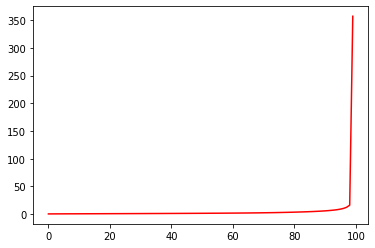

In [36]:
plt.plot(range(len(per100)), per100, c='r')
plt.show()

In [37]:
per100[-20:]

,speed_pred
80,3.574716
81,3.732111
82,3.899814
83,4.073658
84,4.262101
85,4.477566
86,4.700298
87,4.967058
88,5.241308
89,5.561713


In [38]:
kf = KF()

tmp = test_data.copy()
th_delta = 0.0001
th = 45 
th_dis_speed = 16
th_dis = 13
# 5.006
# tmp.loc[((tmp['lngDeg_mean_delta_3'] > th_delta) | (tmp['latDeg_mean_delta_3'] > th_delta) | \
#          (tmp['lngDeg_mean_delta_2'] > th_delta) | (tmp['latDeg_mean_delta_2'] > th_delta) | \
#          (tmp['lngDeg_mean_delta_1'] > th_delta) | (tmp['latDeg_mean_delta_1'] > th_delta) | \
#          (tmp['dist_between_base_and_kf'] > 10) | \
#          (tmp['heightAboveWgs84EllipsoidM'] > 189) | (tmp['heightAboveWgs84EllipsoidM'] < -100) | \
#          (pred['dis_pred'] > th_dis))
#         , ['latDeg', 'lngDeg']] = np.nan 


# dis 2170

print(tmp.loc[((pred['speed_pred'] > th_dis_speed) | (pred['dis'] > th_dis))
        , ['latDeg', 'lngDeg']])

tmp.loc[((pred['speed_pred'] > th_dis_speed) | (pred['dis'] > th_dis))
        , ['latDeg', 'lngDeg']] = np.nan

          latDeg      lngDeg
17     37.416647 -122.082035
18     37.416504 -122.082309
19     37.416576 -122.082096
61     37.416542 -122.082116
62     37.416674 -122.081948
...          ...         ...
91301  37.333905 -121.895827
91339  37.332004 -121.900210
91340  37.331923 -121.900563
91342  37.332159 -121.900446
91475  37.334563 -121.899364

[2605 rows x 2 columns]


In [39]:
kf.apply_kf_smoothing(tmp, "")
smoothed_tmp = mean_with_other_phones(tmp)

100%|██████████| 48/48 [00:45<00:00,  1.05it/s]


In [40]:
data_sub = pd.read_csv('../input/google-smartphone-decimeter-challenge' + '/' + 'sample_submission.csv')
df_sub = data_sub[['phone', 'millisSinceGpsEpoch']].merge(
    smoothed_tmp[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['phone', 'millisSinceGpsEpoch'],
    how='inner')

In [41]:
df_sub.to_csv("./submission_keras_ann_speed_{}_dis_{}.csv".format(th_dis_speed, th_dis), index=False)